<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/%EA%B9%80%EC%A7%84%EA%B7%BC/LSTM_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from keras.layers import RNN
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.layers.core import Activation, Dense, Dropout
from keras import layers, models
from sklearn import preprocessing
from keras import datasets
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [4]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

In [5]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [6]:
A = 1
H = 1
Q = 0.0001
R = 0.01

x_0 = df[0]
P_0 = 1

In [7]:
n_samples = len(df)

In [8]:
x_esti, P = None, None
esti_save = np.zeros(n_samples)

In [9]:
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(df[i], x_esti, P)
        
    esti_save[i] = x_esti

In [10]:
new_df = pd.Series(esti_save)

Text(0, 0.5, 'Voltage [V]')

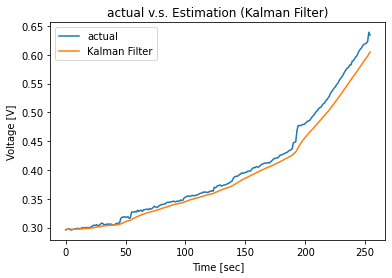

In [11]:
plt.plot(df, label='actual')
plt.plot(esti_save, label='Kalman Filter')
plt.legend(loc='upper left')
plt.title('actual v.s. Estimation (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')

In [12]:
forecasting=20

In [13]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled_train = df_scaled.loc[:,]
df_scaled_train.columns = scale_cols


In [15]:
train_sc_df = pd.DataFrame(df_scaled_train, columns=['Resistance'], index=df_scaled_train.index)
train_sc_df

,Resistance
0,0.000000
1,0.002915
2,0.005831
3,0.005831
4,0.000000
...,...
250,0.941691
251,0.944606
252,0.953353
253,1.000000


In [16]:
for s in range(1, 21):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Resistance'].shift(s)

train_sc_df.head(13)

,Resistance,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.005831,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005831,0.005831,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.005831,0.005831,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000000,0.000000,0.005831,0.005831,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.002915,0.000000,0.000000,0.005831,0.005831,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.002915,0.002915,0.000000,0.000000,0.005831,0.005831,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.005831,0.002915,0.002915,0.000000,0.000000,0.005831,0.005831,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.005831,0.005831,0.002915,0.002915,0.000000,0.000000,0.005831,0.005831,0.002915,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
X_train = train_sc_df.dropna().drop('Resistance', axis=1)
y_train = train_sc_df.dropna()[['Resistance']]


X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20
20,0.011662,0.011662,0.011662,0.011662,0.008746,0.011662,0.008746,0.005831,0.005831,0.008746,0.005831,0.005831,0.002915,0.002915,0.000000,0.000000,0.005831,0.005831,0.002915,0.000000
21,0.011662,0.011662,0.011662,0.011662,0.011662,0.008746,0.011662,0.008746,0.005831,0.005831,0.008746,0.005831,0.005831,0.002915,0.002915,0.000000,0.000000,0.005831,0.005831,0.002915
22,0.014577,0.011662,0.011662,0.011662,0.011662,0.011662,0.008746,0.011662,0.008746,0.005831,0.005831,0.008746,0.005831,0.005831,0.002915,0.002915,0.000000,0.000000,0.005831,0.005831
23,0.017493,0.014577,0.011662,0.011662,0.011662,0.011662,0.011662,0.008746,0.011662,0.008746,0.005831,0.005831,0.008746,0.005831,0.005831,0.002915,0.002915,0.000000,0.000000,0.005831
24,0.023324,0.017493,0.014577,0.011662,0.011662,0.011662,0.011662,0.011662,0.008746,0.011662,0.008746,0.005831,0.005831,0.008746,0.005831,0.005831,0.002915,0.002915,0.000000,0.000000


In [18]:
X_train = X_train.values

y_train = y_train.values

In [19]:
X_train_t = X_train.reshape(X_train.shape[0], -1, 1)

In [20]:
X_train_t.shape # train data는 모든 저항 데이터

(235, 20, 1)

In [21]:
model = Sequential()
model.add(LSTM(30, 
               input_shape=(20, 1), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
h = model.fit(X_train_t, y_train, 
                    epochs=100, 
                    batch_size=1, verbose=2)

Epoch 1/100
235/235 - 23s - loss: 0.0280 - mse: 0.0280
Epoch 2/100
235/235 - 1s - loss: 7.6107e-04 - mse: 7.6107e-04
Epoch 3/100
235/235 - 1s - loss: 6.0584e-04 - mse: 6.0584e-04
Epoch 4/100
235/235 - 1s - loss: 6.2239e-04 - mse: 6.2239e-04
Epoch 5/100
235/235 - 1s - loss: 6.0162e-04 - mse: 6.0162e-04
Epoch 6/100
235/235 - 1s - loss: 5.6234e-04 - mse: 5.6234e-04
Epoch 7/100
235/235 - 1s - loss: 6.9783e-04 - mse: 6.9783e-04
Epoch 8/100
235/235 - 1s - loss: 5.2715e-04 - mse: 5.2715e-04
Epoch 9/100
235/235 - 1s - loss: 5.3088e-04 - mse: 5.3088e-04
Epoch 10/100
235/235 - 1s - loss: 5.5520e-04 - mse: 5.5520e-04
Epoch 11/100
235/235 - 1s - loss: 8.0024e-04 - mse: 8.0024e-04
Epoch 12/100
235/235 - 1s - loss: 5.1746e-04 - mse: 5.1746e-04
Epoch 13/100
235/235 - 1s - loss: 4.1934e-04 - mse: 4.1934e-04
Epoch 14/100
235/235 - 1s - loss: 5.0478e-04 - mse: 5.0478e-04
Epoch 15/100
235/235 - 1s - loss: 4.6205e-04 - mse: 4.6205e-04
Epoch 16/100
235/235 - 1s - loss: 6.6631e-04 - mse: 6.6631e-04
Epoch 17

In [37]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
print(test_df)
test_df = test_df['Resistance']
lengh = round(len(test_df)*0.7)
test = df.loc[:lengh,]
# test = df.loㄴc[:,]

        MeasuredDate  CellNo  Resistance  Volt  Temp
0      2011.3.7 6:27      19       0.243  2.23   -20
1     2011.3.7 18:29      19       0.242  2.23   -20
2      2011.3.8 6:29      19       0.244  2.23   -20
3     2011.3.8 18:29      19       0.243  2.23   -20
4      2011.3.9 6:29      19       0.243  2.23   -20
..               ...     ...         ...   ...   ...
247  2011.8.29 17:28      19       0.254  2.23   -20
248   2011.8.30 5:28      19       0.255  2.23   -20
249  2011.8.30 17:28      19       0.253  2.23   -20
250   2011.8.31 5:28      19       0.254  2.23   -20
251  2011.8.31 16:12      19       0.259  2.23   -20

[252 rows x 5 columns]


In [38]:
scale_cols = ['Resistance']
scaler = MinMaxScaler()
test_df = pd.DataFrame(test_df)
test_df.columns = scale_cols
df_scaled_test = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled_test)
df_scaled_test = df_scaled.loc[:lengh,]
# df_scaled_test = df_scaled
df_scaled_test.columns = scale_cols

print(df_scaled_test.head(30))

    Resistance
0         0.20
1         0.15
2         0.25
3         0.20
4         0.20
5         0.15
6         0.15
7         0.20
8         0.20
9         0.15
10        0.15
11        0.15
12        0.10
13        0.15
14        0.15
15        0.15
16        0.10
17        0.15
18        0.20
19        0.15
20        0.20
21        0.20
22        0.20
23        0.15
24        0.15
25        0.15
26        0.10
27        0.10
28        0.10
29        0.10


In [39]:
test_sc_df = pd.DataFrame(df_scaled_test, columns=['Resistance'], index=df_scaled_test.index)

In [40]:
for s in range(1, 21):
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Resistance'].shift(s)

test_sc_df.head(13)

,Resistance,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20
0,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.25,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.20,0.25,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.20,0.20,0.25,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.15,0.20,0.20,0.25,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.15,0.15,0.20,0.20,0.25,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.20,0.15,0.15,0.20,0.20,0.25,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.20,0.20,0.15,0.15,0.20,0.20,0.25,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.15,0.20,0.20,0.15,0.15,0.20,0.20,0.25,0.15,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
X_test = test_sc_df.dropna().drop('Resistance', axis=1)
y_test = test_sc_df.dropna()[['Resistance']]

X_test

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20
20,0.15,0.20,0.15,0.10,0.15,0.15,0.15,0.10,0.15,0.15,0.15,0.20,0.20,0.15,0.15,0.20,0.20,0.25,0.15,0.20
21,0.20,0.15,0.20,0.15,0.10,0.15,0.15,0.15,0.10,0.15,0.15,0.15,0.20,0.20,0.15,0.15,0.20,0.20,0.25,0.15
22,0.20,0.20,0.15,0.20,0.15,0.10,0.15,0.15,0.15,0.10,0.15,0.15,0.15,0.20,0.20,0.15,0.15,0.20,0.20,0.25
23,0.20,0.20,0.20,0.15,0.20,0.15,0.10,0.15,0.15,0.15,0.10,0.15,0.15,0.15,0.20,0.20,0.15,0.15,0.20,0.20
24,0.15,0.20,0.20,0.20,0.15,0.20,0.15,0.10,0.15,0.15,0.15,0.10,0.15,0.15,0.15,0.20,0.20,0.15,0.15,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.65,0.65,0.65,0.65,0.55,0.50,0.50,0.60,0.60,0.60,0.60,0.60,0.55,0.55,0.65,0.65,0.65,0.65,0.55,0.55
173,0.60,0.65,0.65,0.65,0.65,0.55,0.50,0.50,0.60,0.60,0.60,0.60,0.60,0.55,0.55,0.65,0.65,0.65,0.65,0.55
174,0.60,0.60,0.65,0.65,0.65,0.65,0.55,0.50,0.50,0.60,0.60,0.60,0.60,0.60,0.55,0.55,0.65,0.65,0.65,0.65
175,0.55,0.60,0.60,0.65,0.65,0.65,0.65,0.55,0.50,0.50,0.60,0.60,0.60,0.60,0.60,0.55,0.55,0.65,0.65,0.65


In [42]:
X_test= X_test.values
y_test = y_test.values

In [43]:
X_test_t = X_test.reshape(X_test.shape[0], 20, 1)

In [44]:
X_test_t.shape #테스트데이터는 저항데이터의 70프로

(157, 20, 1)

In [45]:
pred = model.predict(X_test_t)

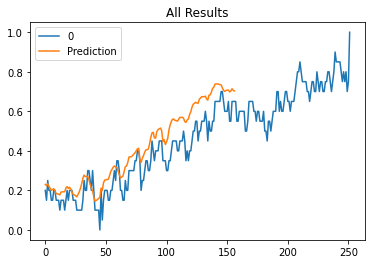

In [56]:
x_list = [] # 미래 30프로 예측 수정중입니다.
for i in range(0, lengh-forecasting+1):
     x_list.append(np.array(i))
       
df_scaled.plot()
plt.plot(x_list, pred, label='Prediction')
plt.legend(loc=0)
plt.title('All Results')
plt.show()